## Dataset Description and Setup

We are working with the **cats_vs_dogs** dataset, which consists of images of cats and dogs across 34 different breeds. Each example in this dataset is a 224x224x3 image, where the last dimension represents the 3 color channels in RGB encoding. The dataset is divided into three parts: training, validation (dev), and testin The aim of this assignment is to **predict breeds of cats and dogs based on images.**gpre-trained model, **EfficientNet**, which will be used to initialize our model and potentially imp.rove the training



### Data Details

- **Training and Validation Datasets**:
  - These datasets are stored in TFRecord files.
  - Each element is encoded as a `tf.train.Example`.
  - True labels are provided for these datasets and should be used for training the model and validation (including early stopping).

- **Test Dataset**:
  - This dataset is given as a pickled list.
  - It lacks labels and should only be used for making predictions and submission.

### Pre-trained Model

We are provided with weights of a pre-trained model

# Imports

In [2]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

from DS_2_2024_HW2_efficient_net import EfficientNet

In [2]:
tf.keras.utils.set_random_seed(16)

## Data

In this section, we are processing the mentioned dataset of images of cats and dogs, each belonging to one of 34 breeds. We define constants for the image dimensions and number of breeds, and implement a function to parse and preprocess the data. The training and validation datasets are stored in TFRecord files, which we load and process using TensorFlow's `TFRecordDataset` class and a parsing function from practicals to decode the images and mask.. The test dataset is provided as a pickled list, which we load using Python's `pickle` module and convert into a TensorFlow dataset. This preprocessing ensures the data is in the correct format for training and evaluating a machine learning model.


In [15]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

In [16]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")
    
# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

with open("hw2_outofsample.pickle", 'rb') as f:
    test = pickle.load(f)
test = tf.data.Dataset.from_tensor_slices(test) # see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Data exploration

Next we would like to briefly epxlore the given dataset. There are 2142 + 306 entries, where each label has 63 pictures ( 9 resp. for dev). On the first glance we did not spot any anomalies or irrelevant entry.

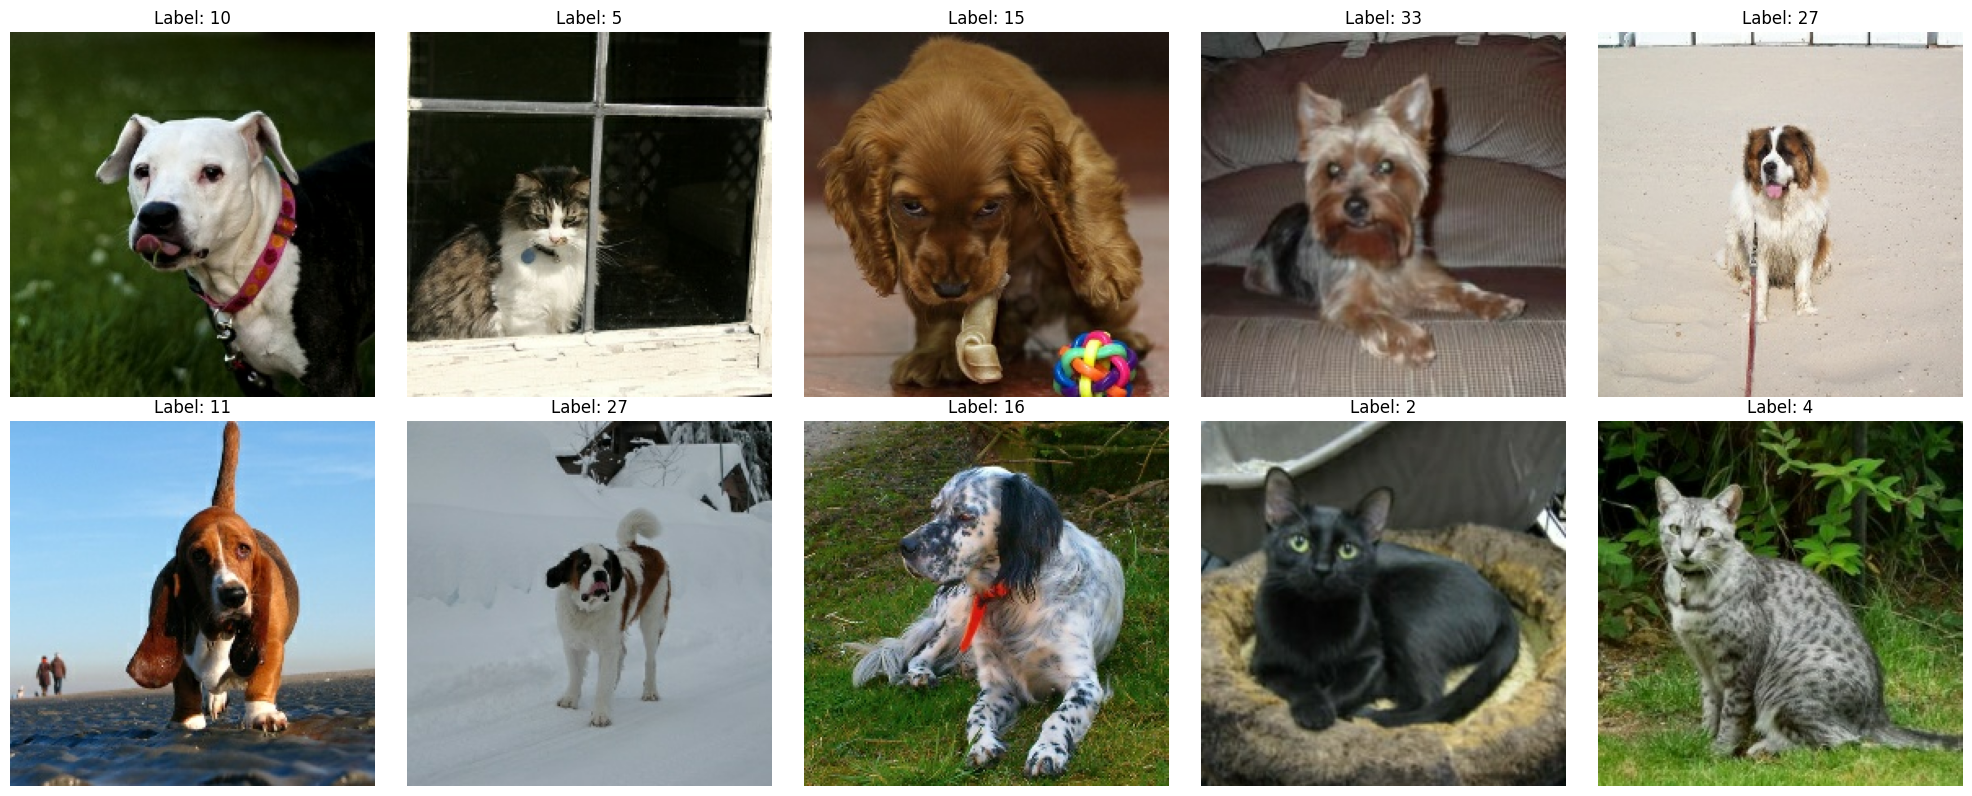

In [22]:
def display_images(dataset, num_images):
    columns = 5
    rows = (num_images + columns - 1) // columns  # Calculate required rows for given number of images
    plt.figure(figsize=(columns * 4, rows * 4))  # Adjust the figure size

    for idx, data in enumerate(dataset.take(num_images)):
        image, label = data['image'], data['label']
        plt.subplot(rows, columns, idx + 1)  # Specify subplot position
        plt.imshow(image.numpy())  # Display the image
        plt.title(f"Label: {label.numpy()}")  # Add title with label
        plt.axis('off')  # Hide axes for a cleaner look

    plt.tight_layout()  # Optimize layout
    plt.show()

# Display the first 10 images from the training dataset
display_images(dev, 10)

# Build Model

Continue by initializing EfficientNet, building the model, augmentation and training.

In [5]:
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition

# Create the EfficientNet model
base_model = EfficientNet(
    default_resolution=(224),
    width_coefficient=1.0,
    depth_coefficient=1.0,
    include_top=False,
    weights='efficientnet.h5',
    dropout_rate=0.2
)

# Summary of the model architecture
base_model.summary()

Model: "efficientnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                      

In [6]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization): #BatchNormalization layers are typically kept trainable to allow them to adapt during fine-tuning.
        layer.trainable = True
    else:
        layer.trainable = False

# We don't want to print out all the layers again, only number of (non-)trainable parameters
def custom_summary(model):
    total_params = model.count_params()
    trainable_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable_params = total_params - trainable_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

# Call the custom summary function
custom_summary(base_model)

Total parameters: 4049564
Trainable parameters: 42016
Non-trainable parameters: 4007548


In [7]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through Efficient model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

inputs = tf.keras.layers.Input([H, W, C])
hidden = base_model(inputs)[0]
dense = tf.keras.layers.Dense(32, activation = tf.nn.relu)(hidden)
outputs = tf.keras.layers.Dense(34, activation = tf.nn.softmax)(dense)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 34)                1122      
                                                             

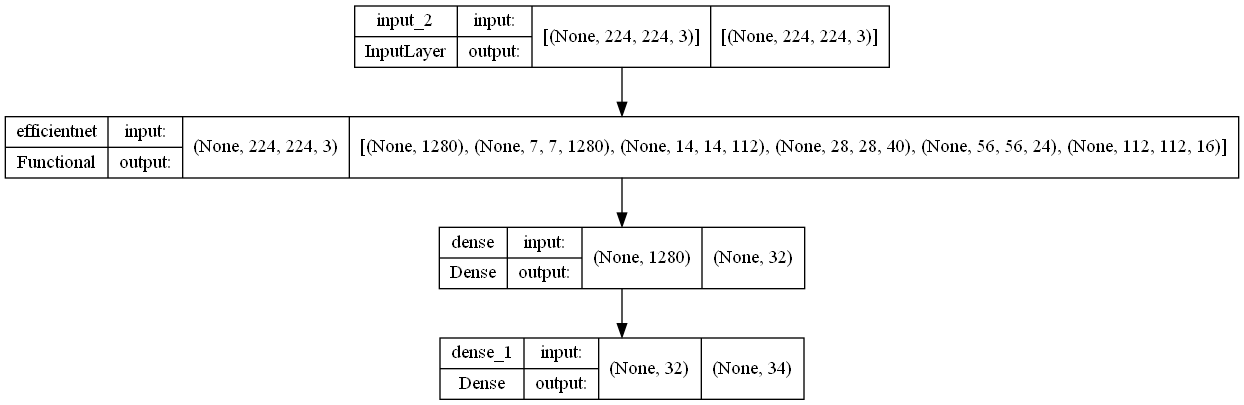

In [8]:
#Extra ze cvičení

# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())


#Note - doporučuje smoothing po augment train?

## Augmentation

In [11]:
# We define pipeline that will consist of augmentation and batching

def augment_train(input):
    image = input['image']
    label = input['label']
    # Augmentation procedures (modify to your wish)

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])

    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    # Augmentation procedures (add to your wish)
    # Note: if we add augmentation also to dev dataset, we can assume that
    # performance of test dataset will be better as test dataset is not augmented
    
    return image, label


In [12]:

# Now we apply augmentation using .map()
train = train.map(augment_train)
validation= dev.map(augment_dev)

batch_size = 32 
# Apply .batch() to 'train' and 'dev' with some choice of batch size
train = train.batch(batch_size)
validation = validation.batch(batch_size)

In [14]:
# Fit your model using early stopping

epochs = 8 #We tried several variants, the 

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/train')

model.fit(train,
          epochs=epochs,
          validation_data=validation,
          callbacks=[early_call])

Epoch 1/50
     67/Unknown - 443s 7s/step - loss: 0.5870 - sparse_categorical_accuracy: 0.8581WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
67/67 [==============================] - 455s 7s/step - loss: 0.5870 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.4092 - val_sparse_categorical_accuracy: 0.8627
Epoch 2/50
67/67 [==============================] - 401s 6s/step - loss: 0.4100 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.3473 - val_sparse_categorical_accuracy: 0.8824
Epoch 3/50
67/67 [==============================] - 394s 6s/step - loss: 0.3091 - sparse_categorical_accuracy: 0.9295 - val_loss: 0.3242 - val_sparse_categorical_accuracy: 0.8856
Epoch 4/50
67/67 [==============================] - 397s 6s/step - loss: 0.2322 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.2840 - val_sparse_categorical_accuracy: 0.90

# Evaluate

At last, we convert the test into a TensorFlow dataset and apply batching with a same batch size of 32. Using a pre-trained model, we predict the class probabilities for each batch in the test dataset. The predicted probabilities are then converted to class labels by selecting the class with the highest probability for each example. Finally, we store the predicted class labels in a CSV file for submission.


In [15]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)

# Apply batching also to 'test'
#test = test.batch(batch_size)
batch_size = 32 
test = test.batch(batch_size)
# Predict
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

# Store results
pd.DataFrame({'ID, TARGET': test_prediction}).to_csv('data/hw2_outofsample_prediction.csv', index=True, header=True)